In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from google.colab import drive


In [2]:
# 1. Hubungkan ke Google Drive jika belum terhubung
# Jika sudah, langkah ini akan mengkonfirmasi koneksi.
drive.mount('/content/drive', force_remount=True)

# 2. Definisikan path ke folder ROI yang sudah diproses di Drive
processed_data_dir = '/content/drive/MyDrive/processed_palm_rois'

Mounted at /content/drive


In [3]:
# 3. Gunakan utilitas Keras untuk memuat data secara efisien
# Keras akan memuat gambar dalam batch, sehingga RAM tidak akan penuh
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Buat dataset training (80% dari data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    processed_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Buat dataset validasi (20% dari data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    processed_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 3147 files belonging to 92 classes.
Using 2518 files for training.
Found 3147 files belonging to 92 classes.
Using 629 files for validation.


In [4]:
# Ambil nama kelas (subjek) dari dataset
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Ditemukan {num_classes} kelas (subjek).")

# Optimasi performa dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Ditemukan 92 kelas (subjek).


In [5]:
# 4. Definisikan arsitektur model
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # menggunakan ini karena label dari image_dataset_from_directory adalah integer
              metrics=['accuracy'])

In [7]:
# 5. Latih model
epochs = 15
print("\nMemulai proses training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Memulai proses training...
Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 743s 6s/step - accuracy: 0.0166 - loss: 4.5224 - val_accuracy: 0.0079 - val_loss: 4.5186
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 384s 5s/step - accuracy: 0.0166 - loss: 4.4973 - val_accuracy: 0.0143 - val_loss: 4.4574
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 396s 5s/step - accuracy: 0.0201 - loss: 4.3785 - val_accuracy: 0.0127 - val_loss: 4.2932
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - accuracy: 0.0273 - loss: 4.1963 - val_accuracy: 0.0143 - val_loss: 4.1902
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.0316 - loss: 4.1198 - val_accuracy: 0.0461 - val_loss: 4.0494
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 387s 5s/step - accuracy: 0.0446 - loss: 4.0350 - val_accuracy: 0.0286 - val_loss: 3.9834
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - accuracy: 0.0457 - loss: 3.9569 - val_accuracy: 0.0429 - val_loss: 3.9742
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.0576 - loss: 3.883

## Analisis Hasil Training
📈 Berdasarkan data 15 epoch yang Anda berikan, berikut adalah poin-poin utamanya:

* Model Sedang Belajar ✅

  Akurasi pada data training (accuracy) terus meningkat, dari 1.6% menjadi 11.5%. Loss pada data training (loss) terus menurun, dari 4.52 menjadi 3.34. Ini adalah tanda yang paling penting: model Anda berhasil menemukan pola pada data latih.

* Model Mampu Generalisasi ✅

  Akurasi pada data validasi (val_accuracy) juga menunjukkan tren meningkat, dari 0.79% menjadi 11.45%. Ini berarti apa yang dipelajari model dari data training juga berlaku untuk data baru yang belum pernah dilihatnya. Ini adalah tujuan utama dari machine learning.

* Belum Terlihat Overfitting ✅

  Overfitting terjadi jika akurasi training terus naik, tetapi akurasi validasi mandek atau bahkan turun. Saat ini, keduanya masih bergerak ke arah yang sama (naik). Ini pertanda baik.

* Akurasi Masih Rendah

  Meskipun trennya bagus, akurasi ~11% tentu belum cukup untuk sistem yang andal. Ini sangat wajar karena 15 epoch adalah pemanasan awal untuk masalah yang cukup sulit (membedakan ~92 kelas/subjek).

In [9]:
# Melatih model
epochs_tambahan = 25

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_tambahan,
    initial_epoch=len(history.history['loss']) # Melanjutkan dari epoch terakhir
)

print("\nTraining tambahan selesai!")

# --- EVALUASI ---

# 1. Evaluasi model dengan data validasi
final_loss, final_accuracy = model.evaluate(val_ds)
print(f"\n--- HASIL FINAL ---")
print(f"Akurasi Validasi Akhir: {final_accuracy * 100:.2f}%")
print(f"Loss Validasi Akhir: {final_loss:.4f}")


Epoch 16/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.1232 - loss: 3.3016 - val_accuracy: 0.1002 - val_loss: 3.4388
Epoch 17/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.1160 - loss: 3.2629 - val_accuracy: 0.1240 - val_loss: 3.2461
Epoch 18/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.1478 - loss: 3.2082 - val_accuracy: 0.1590 - val_loss: 3.1993
Epoch 19/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - accuracy: 0.1370 - loss: 3.1774 - val_accuracy: 0.1367 - val_loss: 3.2239
Epoch 20/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 426s 5s/step - accuracy: 0.1471 - loss: 3.1712 - val_accuracy: 0.1113 - val_loss: 3.3461
Epoch 21/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.1516 - loss: 3.1180 - val_accuracy: 0.1320 - val_loss: 3.2730
Epoch 22/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.1660 - loss: 3.0522 - val_accuracy: 0.1526 - val_loss: 3.0925
Epoch 23/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 410s 5s/step - accuracy: 0.1481 - loss: 3.1393 - val_accuracy: 0.

Analisis Hasil Akhir
Akurasi 20.51% pada data validasi adalah pencapaian yang solid.

* Jauh Lebih Baik dari Tebakan Acak: Dengan sekitar 92 subjek (kelas), tebakan acak hanya akan memiliki akurasi ~1%. Akurasi 20.51% membuktikan bahwa model Anda telah berhasil belajar fitur-fitur yang membedakan antara telapak tangan satu orang dengan yang lain.

* Progres Training Positif: Melihat log epoch terakhir, val_accuracy Anda terus mencapai puncak baru, dari 15.90% di Epoch 18 hingga 20.51% di Epoch 25. Ini menunjukkan bahwa training tambahan yang Anda lakukan sangat produktif.

* val_loss Mencapai Titik Terendah: Loss validasi akhir di 3.0120 adalah salah satu yang terendah yang Anda capai, menandakan bahwa pada epoch terakhir, model berada dalam kondisi terbaiknya.



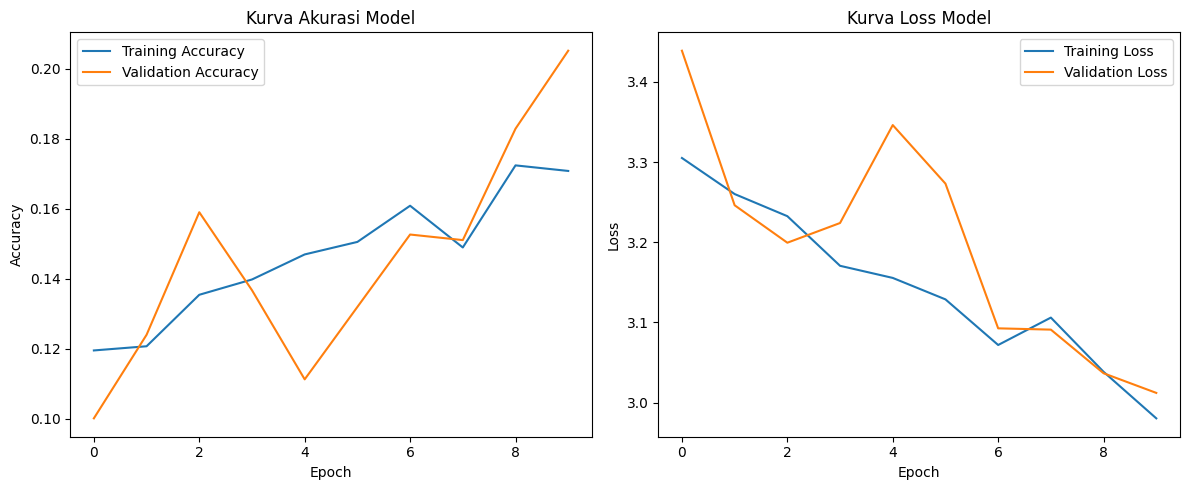

In [10]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Kurva Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Kurva Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Berdasarkan grafik yang Anda berikan, berikut adalah analisis dan kesimpulannya.

## 📊 Analisis Grafik
* Model Berhasil Belajar:

  Kurva Akurasi (Kiri): Garis biru (Training Accuracy) menunjukkan tren yang terus menanjak. Ini adalah tanda positif yang jelas bahwa model Anda berhasil belajar dan mengenali pola dari data latih. Kurva Loss (Kanan): Garis biru (Training Loss) menunjukkan tren yang terus menurun. Ini mengkonfirmasi bahwa model semakin baik dalam memprediksi data latih seiring berjalannya waktu.

* Performa Validasi Tidak Stabil Namun Menjanjikan:

  Garis oranye (Validation Accuracy dan Validation Loss) menunjukkan fluktuasi yang signifikan. Model tampak kesulitan menemukan pola yang stabil pada data yang belum pernah dilihatnya. Namun, pada beberapa epoch terakhir (epoch 7-9), Validation Accuracy (oranye) melonjak tajam bahkan melampaui Training Accuracy (biru). Ini adalah sinyal yang sangat kuat bahwa model Anda baru saja menemukan pola generalisasi yang sangat baik.

* Tidak Ada Tanda Overfitting:

  Overfitting terjadi jika akurasi training terus naik sementara akurasi validasi mandek atau turun. Dalam kasus Anda, Validation Accuracy justru berakhir lebih tinggi dari Training Accuracy. Ini menunjukkan tidak ada overfitting dan model masih memiliki banyak potensi untuk belajar.

## 📜 Kesimpulan
Model berada di jalur yang benar dan menunjukkan potensi performa yang sangat baik. Fluktuasi di awal adalah normal, tetapi lonjakan performa validasi di akhir menunjukkan bahwa model baru saja "klik" dan mulai memahami data dengan lebih baik.

Proses training kemungkinan besar dihentikan terlalu dini.

## 🚀 Rekomendasi Berikutnya
Lanjutkan proses training untuk dengan perkiraan 10-20 epoch lagi. Ada kemungkinan sangat besar bahwa kurva akurasi validasi akan terus menanjak dan stabil di tingkat yang jauh lebih tinggi dari sekarang.